In [24]:
import os, sys
import numpy as np
import cv2
import dlib
from google.colab.patches import cv2_imshow
import scipy.spatial as spatial
from scipy.spatial.distance import euclidean as euclid_distance
%matplotlib inline
from matplotlib import pyplot as plt
import cv2

# upload pictures
!wget -q https://github.com/uol-mediaprocessing/group-projects-group-photo/raw/master/pictures/group_2/index.txt -O group_2.txt
!mkdir group_2


!xargs -i -a group_2.txt wget -q https://github.com/uol-mediaprocessing/group-projects-group-photo/raw/master/pictures/group_2/{} -O group_2/{}
!ls -lah group_2

path = './group_2'

files = os.listdir(path)
files = list(map(lambda f: path + '/' + f, files))
print(files)

imgs = list(map(cv2.imread, files))

# get models
!wget -q  https://github.com/uol-mediaprocessing/group-projects-group-photo/raw/master/shape_predictor_68_face_landmarks.dat.bz2 -O shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2
!wget -q https://github.com/uol-mediaprocessing/group-projects-group-photo/raw/master/dlib_face_recognition_resnet_model_v1.dat.bz2
!bzip2 -d dlib_face_recognition_resnet_model_v1.dat.bz2
!wget https://raw.githubusercontent.com/opencv/opencv/3.4/data/haarcascades/haarcascade_smile.xml

mkdir: cannot create directory ‘group_2’: File exists
total 40M
drwxr-xr-x 2 root root 4.0K Jan 16 11:20 .
drwxr-xr-x 1 root root 4.0K Jan 16 12:05 ..
-rw-r--r-- 1 root root 3.7M Jan 16 12:38 IMG_20191112_111241.jpg
-rw-r--r-- 1 root root 3.6M Jan 16 12:38 IMG_20191112_111244.jpg
-rw-r--r-- 1 root root 4.0M Jan 16 12:38 IMG_20191112_111256.jpg
-rw-r--r-- 1 root root 3.9M Jan 16 12:38 IMG_20191112_111257.jpg
-rw-r--r-- 1 root root 3.8M Jan 16 12:38 IMG_20191112_111300.jpg
-rw-r--r-- 1 root root 4.2M Jan 16 12:38 IMG_20191112_111301.jpg
-rw-r--r-- 1 root root 3.8M Jan 16 12:38 IMG_20191112_111313.jpg
-rw-r--r-- 1 root root 3.3M Jan 16 12:38 IMG_20191112_111315.jpg
-rw-r--r-- 1 root root 3.4M Jan 16 12:38 IMG_20191112_111327.jpg
-rw-r--r-- 1 root root 3.5M Jan 16 12:38 IMG_20191112_111330.jpg
-rw-r--r-- 1 root root 3.3M Jan 16 12:38 IMG_20191112_111332.jpg
['./group_2/IMG_20191112_111327.jpg', './group_2/IMG_20191112_111313.jpg', './group_2/IMG_20191112_111300.jpg', './group_2/IMG_2019111

smiles found: 0
smiles found: 1
2.273901240900159
smiles found: 1
1.5314327757805586
smiles found: 1
2.0761014837771654
smiles found: 1
2.0174743104726076
smiles found: 1
2.6766838524490595
smiles found: 1
1.735668459907174
smiles found: 0
smiles found: 0
smiles found: 1
1.796885708346963
smiles found: 0
smiles found: 0
smiles found: 0
smiles found: 1
1.6847134176641703
smiles found: 1
1.7052302453666925
smiles found: 0
smiles found: 1
2.4673518668860197
smiles found: 0
smiles found: 0
smiles found: 1
3.293629391118884
smiles found: 0
smiles found: 1
1.2534017376601696
smiles found: 1
1.980457792058587
smiles found: 0
smiles found: 1
2.6455051247030497
smiles found: 0
smiles found: 1
1.7758066542446613
smiles found: 1
1.4952453915029764
smiles found: 0
smiles found: 0
smiles found: 0
smiles found: 0
smiles found: 1
2.3520087767392397
smiles found: 0
smiles found: 0
smiles found: 1
1.878298221156001
smiles found: 0
smiles found: 0
smiles found: 1
2.5814502332359552
10


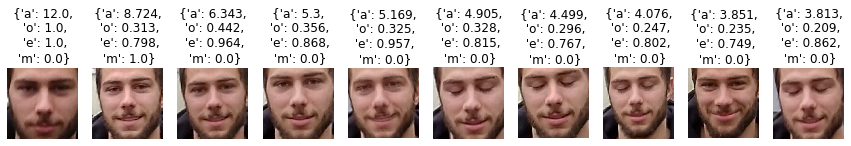

---------
7


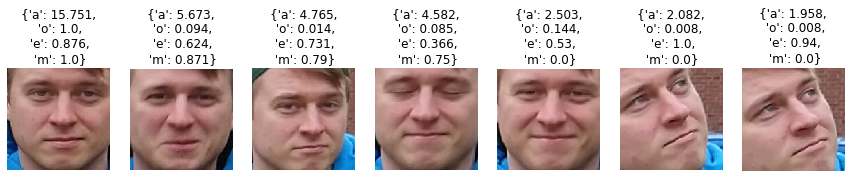

---------
11


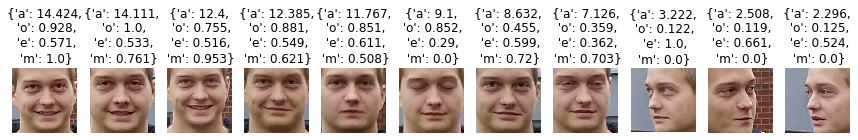

---------
11


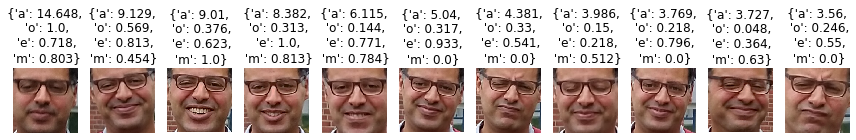

---------


In [26]:
import math 

class Person:
  def __init__(self, id):
    self.id = id
    self.faces = []

  def faceVectorMatches(self, vector):
    return euclid_distance(self.id,vector) < 0.6

  def normalize_scores(self):
    for score_name in ["orientation", "eyes", "mouth"]:
      attr_name = "score_" + score_name
      max = float("-inf")
      for face in self.faces:
        score = getattr(face, attr_name)
        if score > max:
          max = score
      for face in self.faces:
        if max == 0: break
        score = getattr(face, attr_name) / max
        setattr(face, attr_name, score)
      for face in self.faces:
        face.calc_score_all()

class Face:
  def __init__(self, picture_data, picture_index, landmarks):
    self.picture_data = picture_data
    self.picture_index = picture_index
    self.landmarks = landmarks
    self.score_orientation = None # TODO: define metric for orientation
    self.score_eyes = None
    self.score_mouth = None
    self.score_all = None

  def show(self):
    cv2_imshow(self.picture_data)

  def calc_score_eyes(self):
    # compute the euclidean distances between the two sets of
    # vertical eye landmarks (x, y)-coordinates
    landmarks = shape_to_np(self.landmarks)
    left_eye = landmarks[36:42]
    right_eye = landmarks[42:48]
    eyes = [left_eye,right_eye]
    eyes_score = []
    
    for eye in eyes:
      A = euclid_distance(eye[1], eye[5])
      B = euclid_distance(eye[2], eye[4])

      # compute the euclidean distance between the horizontal
      # eye landmark (x, y)-coordinates
      C = euclid_distance(eye[0], eye[3])

      # compute the eye aspect ratio
      ear = (A + B) / (2.0 * C)
      # return the eye aspect ratio
      eyes_score.append(ear)

    self.score_eyes = (eyes_score[0]+eyes_score[1])/2.0


  def calc_score_orientation(self):
    nparray = shape_to_np(landmarks)
    #red = (255, 0, 0)
    #for x in range(len(nparray)):
      #cv2.circle(picture, (nparray[x][0],nparray[x][1]), 3, red, -1)
    # 2, 30 , 14
    dist1 = calculateDistance(nparray[2][0],nparray[2][1],nparray[30][0],nparray[30][1])
    dist2 = calculateDistance(nparray[14][0],nparray[14][1],nparray[30][0],nparray[30][1])
    distRatio = abs(dist2 - dist1)

    self.score_orientation = 1 / distRatio

  def calc_score_mouth(self):
    gray = cv2.cvtColor(cv2.cvtColor(self.picture_data,cv2.COLOR_RGB2BGR),cv2.COLOR_BGR2GRAY)
    smile = face_cascade_smile.detectMultiScale3(
        gray,
        scaleFactor=1.8,
        minNeighbors=20,
        minSize=(30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE,
        outputRejectLevels = True
    )
    rects = smile[0]
    weights = smile[2]
    print("smiles found: "+str(len(rects)))
    if len(weights) == 1:
      self.score_mouth = float(weights[0])
      print(float(weights[0]))
    else:
      self.score_mouth = 0

  def calc_scores(self):
    self.calc_score_orientation()
    self.calc_score_eyes()
    self.calc_score_mouth()

    self.calc_score_all()
    
  # sets and return score_all, parameters are for weighting the scores
  def calc_score_all(self, w1 = 10, w2 = 2, w3 = 4):
    self.score_all = self.score_orientation * w1 + self.score_eyes * w2 + self.score_mouth * w3

  def scores_str(self):
    return str({
        "a": round(self.score_all, 3),
        "o": round(self.score_orientation, 3),
        "e": round(self.score_eyes, 3),
        "m": round(self.score_mouth, 3)
    }).replace(",", ",\n")

# return the face given a picture and the coords of the face
def extractFace(pic, coords):
  return pic[coords.top():coords.bottom(), coords.left():coords.right()]

def shape_to_np(shape, dtype="int"):
	# initialize the list of (x, y)-coordinates
	coords = np.zeros((shape.num_parts, 2), dtype=dtype)

	# loop over all facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, shape.num_parts):
		coords[i] = (shape.part(i).x, shape.part(i).y)

	# return the list of (x, y)-coordinates
	return coords

def calculateDistance(x1,y1,x2,y2):  
     dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
     return dist 

# filenames
landmarks_filename = "shape_predictor_68_face_landmarks.dat"
facerecognition_filename = "dlib_face_recognition_resnet_model_v1.dat"

# TODO: fill pictures with filenames
# upload pictures 
cv_pictures = [cv_img.copy() for cv_img in imgs]
dlib_pictures = [cv2.cvtColor(cv_img,cv2.COLOR_BGR2RGB) for cv_img in cv_pictures]

# init face detection and landmarks
face_detector = dlib.get_frontal_face_detector()
face_landmarks = dlib.shape_predictor(landmarks_filename)
face_recognition = dlib.face_recognition_model_v1(facerecognition_filename)
face_cascade_smile = cv2.CascadeClassifier('haarcascade_smile.xml')

# list of every unique person
persons = []

# iterate each picture and search for faces
for pic_idx, picture in enumerate(dlib_pictures):
  # detect faces in the image
  faces = face_detector(picture, 0)

  # TODO: evlt Schleife angucken, was genau ist d?
  # d is the rectangle of the face
  # get landmarks of each face
  # get id for each face
  for k,d in enumerate(faces):
    landmarks = face_landmarks(picture,d)
    face_id = face_recognition.compute_face_descriptor(picture,landmarks)

    # check if person is already in persons list
    person = next((person for person in persons if person.faceVectorMatches(face_id)), None)
    if person is None:
      person = Person(face_id)
      persons.append(person)

    face = Face(extractFace(picture, d), pic_idx, landmarks)
    face.calc_scores()
    person.faces.append(face)

# Output plots
for person in persons:
  print(len(person.faces))
  person.normalize_scores()
  person.faces.sort(key=lambda face:face.score_all,reverse=True)

  fig, ax = plt.subplots(nrows=1,ncols=len(person.faces),figsize=(15,15))
  for i,a in enumerate(ax):
    a.imshow(person.faces[i].picture_data)
    a.set_title(person.faces[i].scores_str())
    a.axis("off")

  plt.show()
  print("---------")


